# Home Credit Default Risk: Model and Predict
I will use XG Boost to model the data because it can handle null values in the data set. It has also been a successful estimator in previous Kaggle competitions.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Load the data
train = pd.read_csv('train_all.csv', index_col='SK_ID_CURR')
test = pd.read_csv('test_all.csv', index_col='SK_ID_CURR')
target = pd.read_csv('data/application_train.csv', index_col='SK_ID_CURR').TARGET

# Some instances were dropped when preparing the trainning data. Below are the relevant target values.
target = target.loc[train.index]

The base score calculated below will be used in the estimator to deal with the imbalance within the training data.

In [2]:
base_score_estimate = target.mean()

# GridSearchCV with XG Boost to refine the modeling hyperparameters
Besides the search below, I've explored the hyperparameter space intensely, and these hyperparameters yield the best results (at least that I could find).

In [3]:
params = {'learning_rate':[0.075,0.1,0.15],
          'max_depth':[1,2,3,4]}

xgb_model = xgb.XGBClassifier(silent=1, random_state=2049, n_jobs=-1,
                              base_score=base_score_estimate, n_estimators=500)

gridCV = GridSearchCV(xgb_model, params, cv=3, verbose=0,
                      scoring='roc_auc',return_train_score=True)

gridCV.fit(train,target)

cv_result = pd.DataFrame(gridCV.cv_results_)
param_columns = ['param_'+key for key in params.keys()]
cv_columns = ['mean_test_score','std_test_score','rank_test_score'] + param_columns
cv_result[cv_columns].sort_values('rank_test_score').head()

,mean_test_score,std_test_score,rank_test_score,param_max_depth,param_learning_rate
3,0.777290,0.001997,1,4,0.075
6,0.777281,0.001789,2,3,0.1
2,0.776941,0.002279,3,3,0.075
7,0.776822,0.001838,4,4,0.1
10,0.776588,0.001901,5,3,0.15


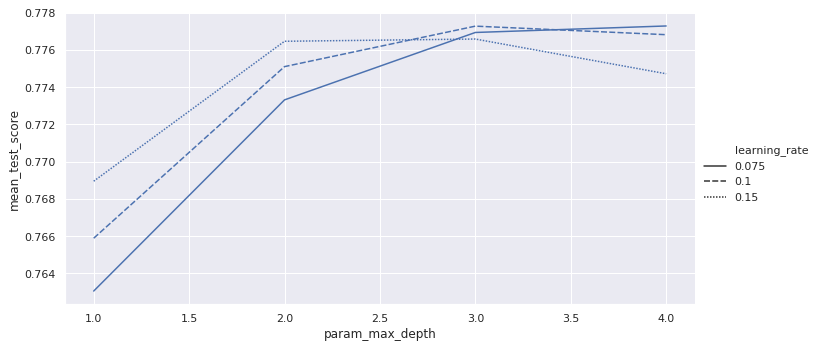

In [4]:
cv_result['learning_rate'] = cv_result['param_learning_rate'].astype('str')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.relplot(x = 'param_max_depth', y = 'mean_test_score', style="learning_rate",
            height=5, aspect=2, kind="line", legend="full", data = cv_result)

# Train final model and make predictions

In [5]:
xgb_model = xgb.XGBClassifier(silent=1, random_state=2049, n_jobs=-1,
                              base_score=base_score_estimate, n_estimators=500,
                              learning_rate=0.075, max_depth=4)

xgb_model.fit(train,target)

XGBClassifier(base_score=0.08072520325203252, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.075, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=2049,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=1)

In [6]:
predictions = xgb_model.predict_proba(test)
predict_neg, predict_pos = zip(*predictions)
results_data = list(predict_pos)

submission_df = pd.DataFrame(data=results_data, 
                             columns=['TARGET'], 
                             index=test.index)
submission_df.head()

,TARGET
SK_ID_CURR,
100001,0.041895
100005,0.155164
100013,0.029941
100028,0.028404
100038,0.174650


In [7]:
submission_df.to_csv('final_submission.csv')